## Hennessy Group: code file for detection of fraudulent amazon reviews

Lets load the dataset and store it as a pandas dataframe

In [1]:
import pandas as pd
data = pd.read_csv("./amazon_reviews_2.csv")
display(data)

,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,1,__label1__,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav..."
1,2,__label1__,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...
2,3,__label1__,3,N,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...
3,4,__label1__,4,N,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...
4,5,__label1__,4,N,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...
...,...,...,...,...,...,...,...,...,...
20995,20996,__label2__,4,Y,Shoes,B00BXYM8T8,"Madden Girl Women's Gettaw Pump,Red Patent,7.5...",wide width is great!,"I bought these for work. I have high arches, ..."
20996,20997,__label2__,4,Y,Shoes,B0014C2ORK,"crocs Unisex Classic Clog,Khaki,6 US Men's / 8...",Love crocs!,Crocs are one of only two brands of shoes that...
20997,20998,__label2__,5,Y,Shoes,B000EX8CCQ,Minnetonka Men's 703 Leather Laced Softsole Mo...,I love moccasins This fit like it was custom m...,I love moccasins This fit like it was custom ...
20998,20999,__label2__,5,Y,Shoes,B00748YHVE,Ariat Womens Unbridled Fatbaby 9 B Powder Brown,"This fit well, comfortable, best investment",I wish these were a little more durable. I got...


### EDA Part 1

Let's look at variable distributions 

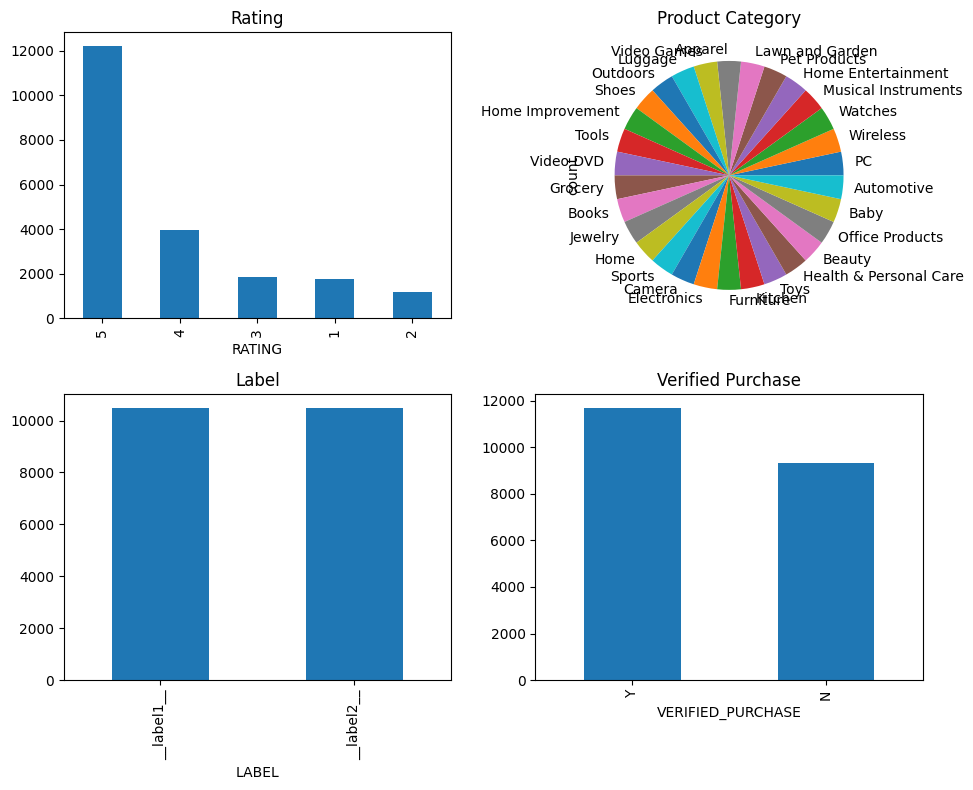

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot data in each subplot
data["RATING"].value_counts().plot(kind="bar", ax=axs[0, 0])
axs[0, 0].set_title("Rating")

data["PRODUCT_CATEGORY"].value_counts().plot(kind="pie", ax=axs[0, 1])
axs[0, 1].set_title("Product Category")

data["LABEL"].value_counts().plot(kind="bar", ax=axs[1, 0])
axs[1, 0].set_title("Label")

data["VERIFIED_PURCHASE"].value_counts().plot(kind="bar", ax=axs[1, 1])
axs[1, 1].set_title("Verified Purchase")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Insights:
- ratings tend to be high
- each product category is evenly distributed (actually 700 rows each, 21000/700 is 30, which is the number of categories; might be a result of sampling stratification)
- same goes for frauds(label2) and non-frauds(label1), each one has 10500 rows
- for verified purchase, Yes and No are similarly distributed but Y is more frequent

Let's show what was said above and then move on to removing ID columns since they don't hold any value to our analysis.

In [3]:
data["LABEL"].value_counts()

LABEL
__label1__    10500
__label2__    10500
Name: count, dtype: int64

In [4]:
data["PRODUCT_CATEGORY"].value_counts().head()

PRODUCT_CATEGORY
PC                     700
Wireless               700
Watches                700
Musical Instruments    700
Home Entertainment     700
Name: count, dtype: int64

In [5]:
data["PRODUCT_CATEGORY"].value_counts().tail()

PRODUCT_CATEGORY
Health & Personal Care    700
Beauty                    700
Office Products           700
Baby                      700
Automotive                700
Name: count, dtype: int64

In [2]:
#removing ID columns
data = data.drop(['DOC_ID','PRODUCT_ID'],axis=1)

We now start our phase of feature engineering, where we extract new fields from those that we already have.

Let's add review and title length fields

In [3]:
data["REVIEW_LENGTH"] = data["REVIEW_TEXT"].apply(len) 
data["REV_TITLE_LENGTH"] = data["REVIEW_TITLE"].apply(len)
display(data.iloc[:,-2:]) 

,REVIEW_LENGTH,REV_TITLE_LENGTH
0,116,6
1,404,21
2,248,24
3,212,16
4,331,21
...,...,...
20995,100,20
20996,115,11
20997,297,57
20998,287,43


### Benford's Law 
We have added new columns to our data and we want to verify that they are reliable, to do this we plot their first digit frequencies against Benford's Law.

We would have done this for all original and new columns, unfortunately "Length" columns are the only ones which can have a first digit through 1 and 9(excluding row IDs). 

In [8]:
def first_digit(n):
    while n >= 10:
        n //= 10
    return n

def benfords_law():
    return {i+1: np.log10(1 + 1/(i+1)) for i in range(9)}

def plot_benfords_law(data,name):
    first_digits = data[name].apply(first_digit)
    counts = first_digits.value_counts(normalize=True)
    counts = counts.sort_index()

    benfords = benfords_law()
    plt.bar(benfords.keys(), benfords.values(), label='Benford\'s Law', color='blue', alpha=0.5)
    plt.scatter(counts.index, counts.values, color='red', label='Observed Data')
    plt.xlabel('First Digit')
    plt.ylabel('Frequency')
    title = 'Benford\'s Law vs. Observed Data for ' + name
    plt.title(title)
    plt.legend()
    plt.show()


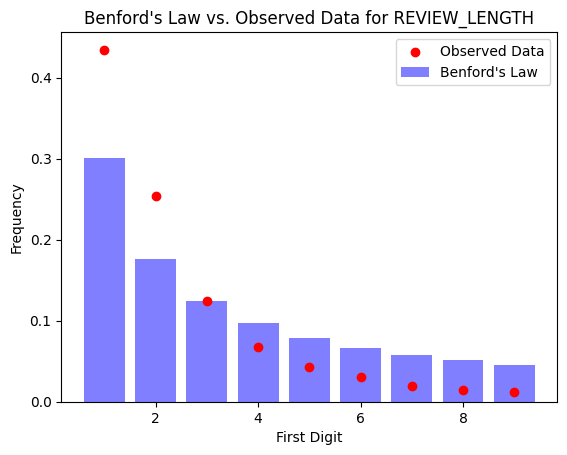

In [9]:
plot_benfords_law(data,"REVIEW_LENGTH")

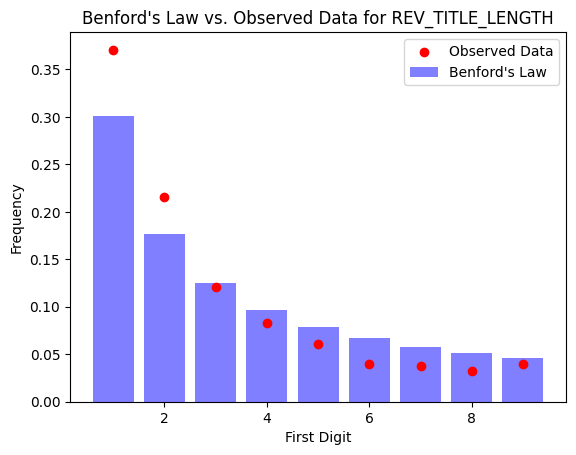

In [10]:
plot_benfords_law(data,"REV_TITLE_LENGTH")

We could say they both follow Benford's Law(even though title length slightly does not perfectly fit the law), making them reliable data.

### NLP for Sentiment Analysis [Feature Engineering]
Next, we will quantify the text fields into sentiment scores.

To analyze sentiment, we will preprocess the text fields as such:
- lowercasing
- removing punctuation
- removing special characters
- tokenizing words
- removing stop words
- stemming words
- removing emojis, URLs and mentions
- joining back review tokens
 
Through nltk library, assigned sentiment score of each review will be polarity score assigned by the SentimentIntensityAnalyzer, values above 0 show a positive sentiment and those under 0 show a negative one. It is also possible to obtain a neutral polarity score, we will not be rounding out the values and rather leave them as the sum of the words.

In [4]:
#Needed libraries
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Downloading nltk resources
import nltk
nltk.download('punkt') # needed for tokenizing
nltk.download('stopwords') # list of english stopwords
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Removing punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Removing special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    # Removing emojis, URLs, and mentions
    tokens = [token for token in tokens if not token.startswith(('http', '@')) and token.encode('ascii', 'ignore').decode('ascii')]
    # Joining tokens back into a single string
    processed_text = ' '.join(tokens)
    
    return processed_text


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Let's add preprocessed review title and review text columns to our data (takes a while)

In [5]:
data["PREPROCESSED_REVIEW"] = data["REVIEW_TEXT"].apply(preprocess_text)
data["PREPROCESSED_TITLE"] = data["REVIEW_TITLE"].apply(preprocess_text)
data[["REVIEW_TITLE","REVIEW_TEXT","PREPROCESSED_TITLE","PREPROCESSED_REVIEW"]]

,REVIEW_TITLE,REVIEW_TEXT,PREPROCESSED_TITLE,PREPROCESSED_REVIEW
0,useful,"When least you think so, this product will sav...",use,least think product save day keep around case ...
1,New era for batteries,Lithium batteries are something new introduced...,new era batteri,lithium batteri someth new introduc market ave...
2,doesn't swing very well.,I purchased this swing for my baby. She is 6 m...,doesnt swing well,purchas swing babi month pretti much grown lou...
3,Great computing!,I was looking for an inexpensive desk calcolat...,great comput,look inexpens desk calcolatur work everyth nee...
4,Only use twice a week,I only use it twice a week and the results are...,use twice week,use twice week result great use teeth whiten s...
...,...,...,...,...
20995,wide width is great!,"I bought these for work. I have high arches, ...",wide width great,bought work high arch use arch support heel high
20996,Love crocs!,Crocs are one of only two brands of shoes that...,love croc,croc one two brand shoe feet day work love cro...
20997,I love moccasins This fit like it was custom m...,I love moccasins This fit like it was custom ...,love moccasin fit like custom made,love moccasin fit like custom made mebr soft c...
20998,"This fit well, comfortable, best investment",I wish these were a little more durable. I got...,fit well comfort best invest,wish littl durabl got caught bolt cross bunk f...


Now we can finally assign a sentiment score to the preprocessed text fields

In [6]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#The sentiment is assessed using the VADER sentiment analysis tool
sid = SentimentIntensityAnalyzer()

def get_sentiment_score(sentence):
    return sid.polarity_scores(sentence)['compound'] 

#lets obtain our sentiment scores for titles and reviews
data["TITLE_SCORE"] = data["PREPROCESSED_TITLE"].apply(get_sentiment_score)
data['REVIEW_SCORE'] = data['PREPROCESSED_REVIEW'].apply(get_sentiment_score)
data[['REVIEW_TITLE','TITLE_SCORE','REVIEW_TEXT','REVIEW_SCORE']]


,REVIEW_TITLE,TITLE_SCORE,REVIEW_TEXT,REVIEW_SCORE
0,useful,0.0000,"When least you think so, this product will sav...",0.4939
1,New era for batteries,0.0000,Lithium batteries are something new introduced...,0.7517
2,doesn't swing very well.,-0.2057,I purchased this swing for my baby. She is 6 m...,0.4059
3,Great computing!,0.6249,I was looking for an inexpensive desk calcolat...,0.0000
4,Only use twice a week,0.0000,I only use it twice a week and the results are...,0.6249
...,...,...,...,...
20995,wide width is great!,0.6249,"I bought these for work. I have high arches, ...",0.4019
20996,Love crocs!,0.6369,Crocs are one of only two brands of shoes that...,0.6369
20997,I love moccasins This fit like it was custom m...,0.8481,I love moccasins This fit like it was custom ...,0.9182
20998,"This fit well, comfortable, best investment",0.8834,I wish these were a little more durable. I got...,0.6486


Now we can carry out a further analysis of the data, by seeing the interactions of our columns such as conditional tables and correlation

### Correlation Analysis

<Axes: >

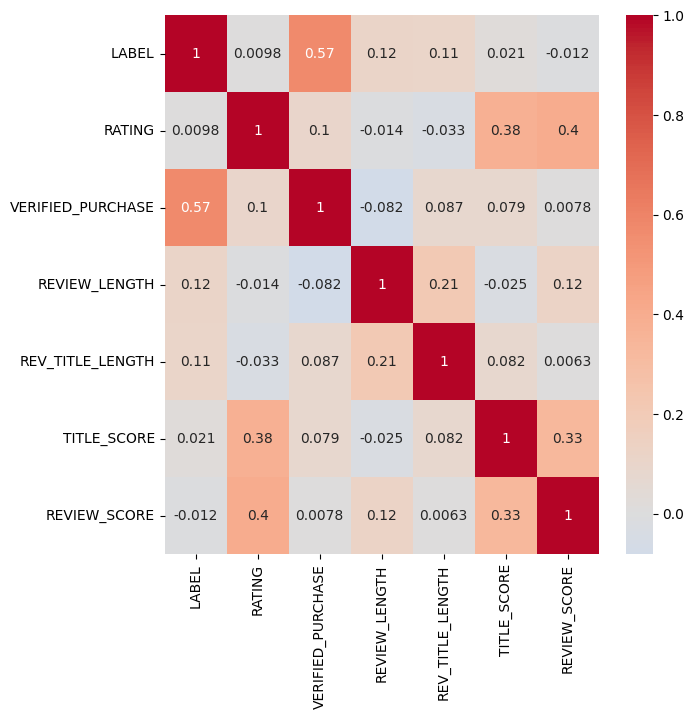

In [7]:
import matplotlib.pyplot as plt
#First, let's turn "LABEL" and "VERIFIED_PURCHASE" fields into numeric to assess their correlations
data["LABEL"] = data["LABEL"].map({"__label1__": 0, "__label2__": 1})
data["VERIFIED_PURCHASE"] = data["VERIFIED_PURCHASE"].map({"N": 0, "Y": 1})
corr = data.corr(numeric_only=True)
#Now that we have the correlation matrix, we can plot a heatmap
import seaborn as sns
plt.figure(figsize=(7, 7))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)

Correlation insights:
- No highly correlated pairs (both negative or positive)
- high positive correlation between review/title score and rating, meaning the more positive a review/title, the higher the assigned star rating
- title score and review score have a correlation of 0.33, this makes sense as the setiment in the title should be matched by thta of the review text.
- highest positive correlation between LABEL and VERIFIED PURCHASE, meaning that a verified purchase often leads to a fraud: since positive correlation implies a positive relationship, verified purchase being 1(true) brings label to a higher value (1, so a fraud) which is not what we expected.
- Other correlations mostly close to 0

### EDA Part 2

Let's find out more about our new variables:

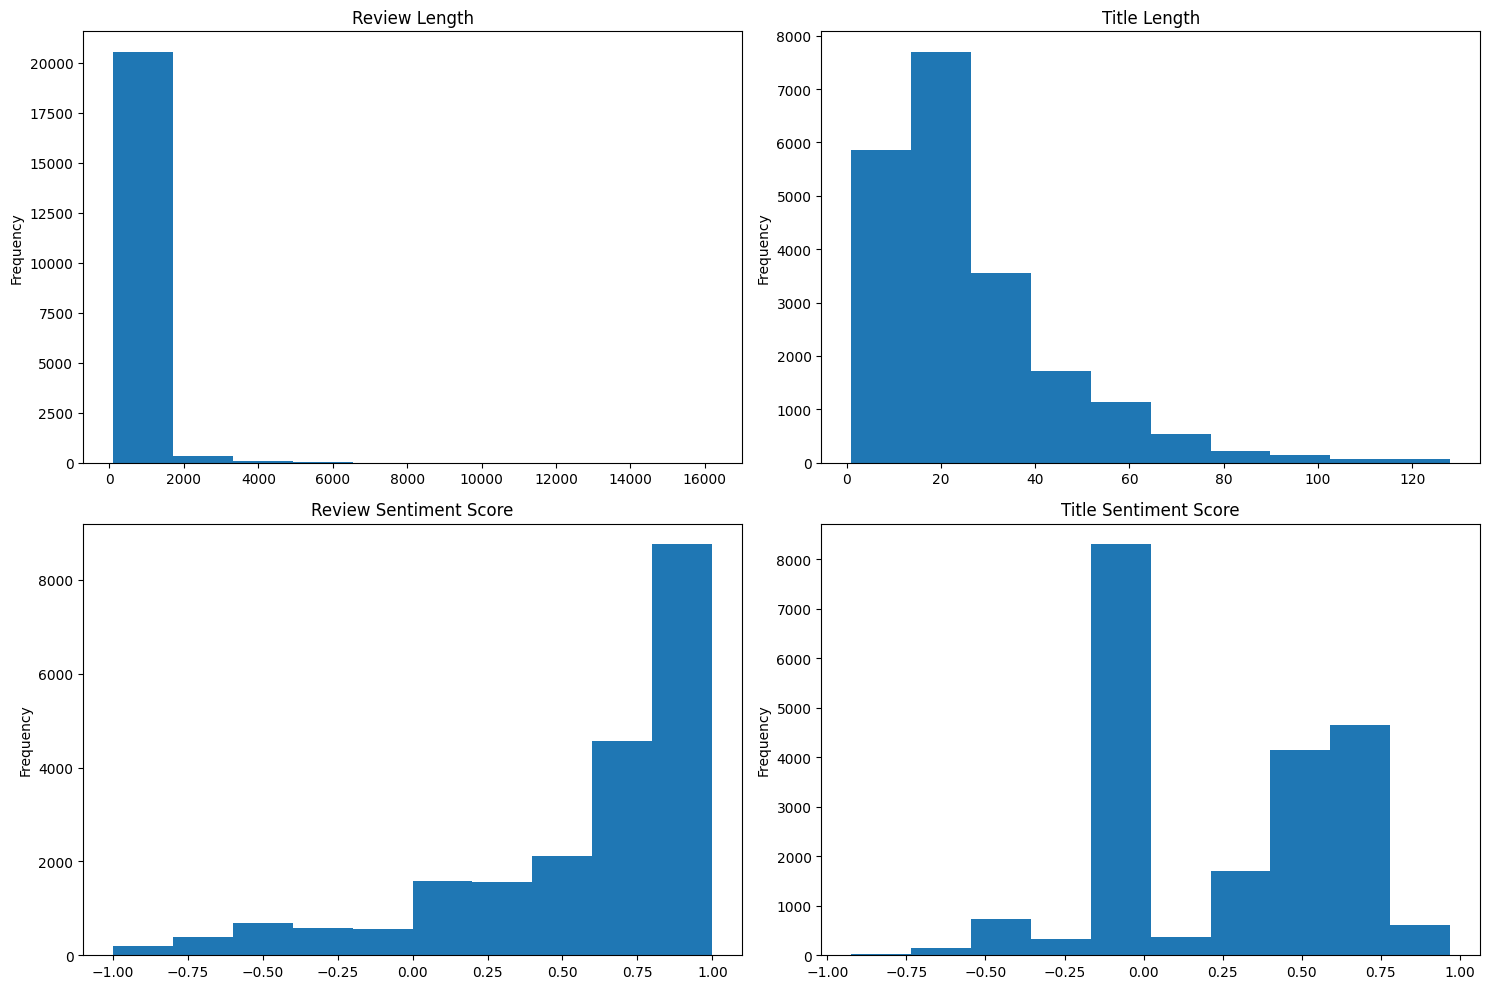

In [19]:
fig, axs = plt.subplots(2, 2,figsize=(15, 10))

# Plot data in each subplot
data["REVIEW_LENGTH"].plot(kind="hist", ax=axs[0,0])
axs[0,0].set_title("Review Length")

data["REV_TITLE_LENGTH"].plot(kind="hist", ax=axs[0,1])
axs[0,1].set_title("Title Length") 

data["REVIEW_SCORE"].plot(kind="hist", ax=axs[1,0])
axs[1,0].set_title("Review Sentiment Score")

data["TITLE_SCORE"].plot(kind="hist", ax=axs[1,1])
axs[1,1].set_title("Title Sentiment Score")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Insights:
- review length is the most skewed
- title length still skewed, but more spread out
- most review sentiments are positive
- title sentiment is mostly neutral, but more positive than negative

In [17]:
#the most outlier-ridden field is review length, there is even a review with 16000 characters
print("Average review length:", round(np.mean(data["REVIEW_LENGTH"]),2),"\nMax review length:", max(data["REVIEW_LENGTH"]))

Average review length: 372.33 
Max review length: 16188


### Fraud Subset analysis

In [8]:
#plot conditional table for LABEL and other fields
fraud_subset = data[data["LABEL"] == 1]
fraud_subset["REVIEW_SCORE"].describe()

count    10500.000000
mean         0.553209
std          0.442741
min         -0.999700
25%          0.361200
50%          0.726900
75%          0.885025
max          0.998400
Name: REVIEW_SCORE, dtype: float64

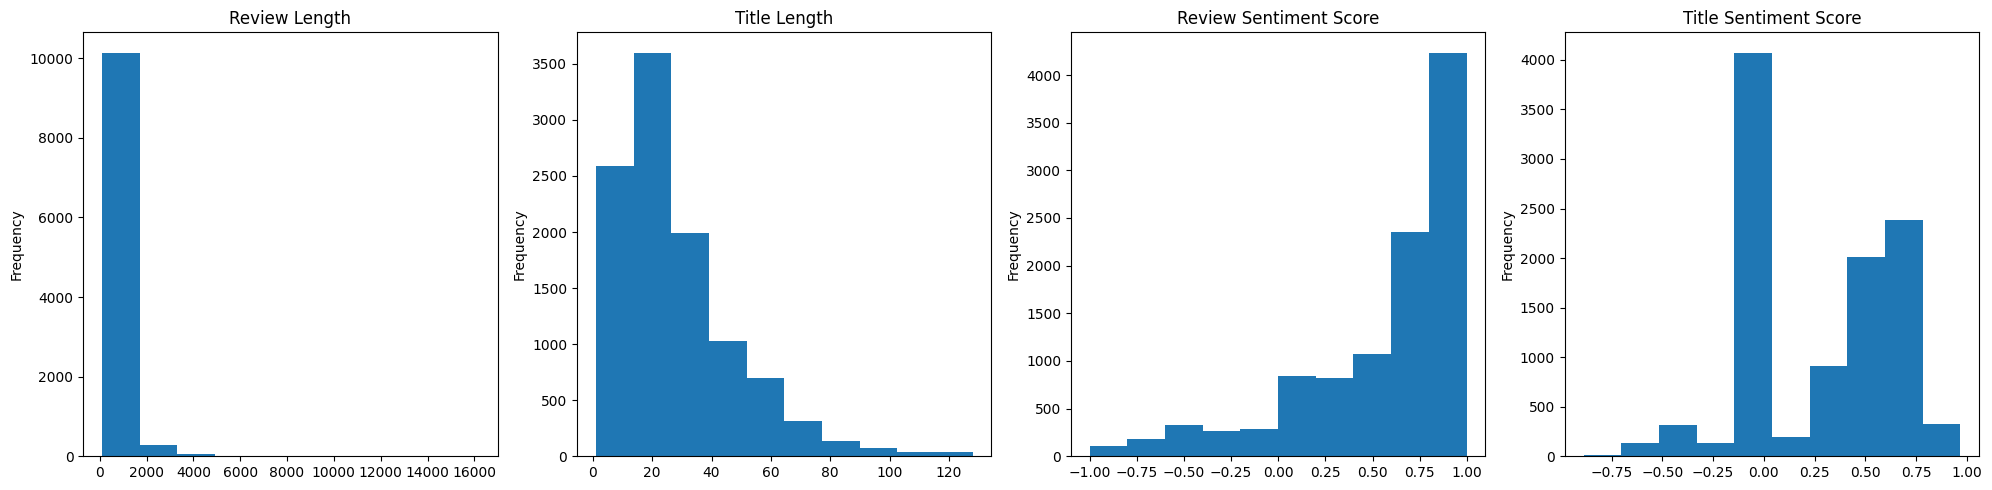

In [19]:
fig, axs = plt.subplots(1, 4,figsize=(20, 5))

# Plot data in each subplot
fraud_subset["REVIEW_LENGTH"].plot(kind="hist", ax=axs[0])
axs[0].set_title("Review Length")

fraud_subset["REV_TITLE_LENGTH"].plot(kind="hist", ax=axs[1])
axs[1].set_title("Title Length") 

fraud_subset["REVIEW_SCORE"].plot(kind="hist", ax=axs[2])
axs[2].set_title("Review Sentiment Score")

fraud_subset["TITLE_SCORE"].plot(kind="hist", ax=axs[3])
axs[3].set_title("Title Sentiment Score")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [20]:
# Let us check usual sentiment in fraud and non frauds:
print("Average sentiment in fraudulent reviews: ", round(data[data["LABEL"]==1]["REVIEW_SCORE"].mean(),4))
print("Average sentiment in non-fraudulent reviews: ", round(data[data["LABEL"]==0]["REVIEW_SCORE"].mean(),4))

Average sentiment in fraudulent reviews:  0.5532
Average sentiment in non-fraudulent reviews:  0.564


We see that sentiment is very similar for both cases and tends to be moderately positive.

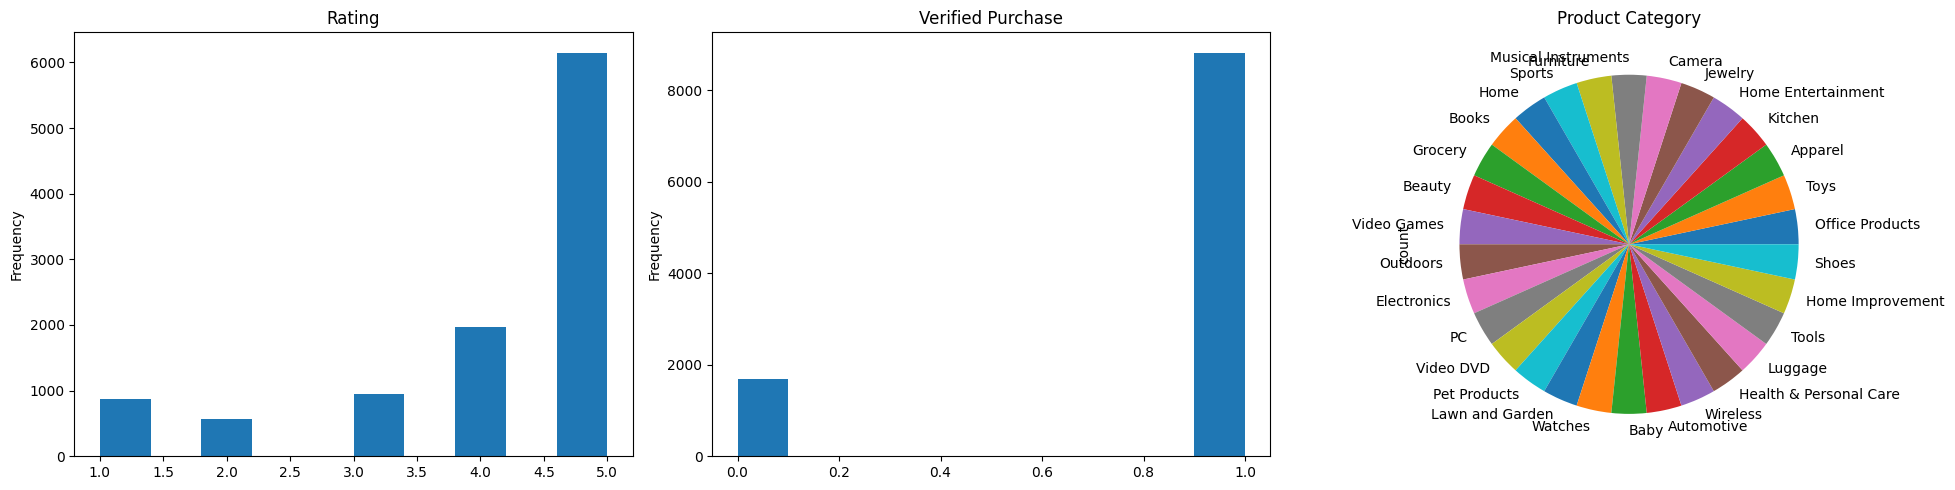

In [21]:
fig, axs = plt.subplots(1, 3,figsize=(20, 5))

# Plot data in each subplot
fraud_subset["RATING"].plot(kind="hist", ax=axs[0])
axs[0].set_title("Rating")

fraud_subset["VERIFIED_PURCHASE"].plot(kind="hist", ax=axs[1])
axs[1].set_title("Verified Purchase") 

fraud_subset["PRODUCT_CATEGORY"].value_counts().plot(kind="pie", ax=axs[2])
axs[2].set_title("Product Category")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Apart from "verified purchase" being 1 more often than not, the fraud dataset does not differ in a major way from the entire dataset, we will have to employ some more advanced techniques to gain insights into how fraudulent reviews are perpetrated.

### Anomaly Detection

Let's find the most anomalous rows, using Anomaly detection through the Isolation Forest algorithm, we know that frauds represent 50% of rows in our dataset, this is similar to the general belief that fake reviews comprise around 30% or 40% of all online reviews, lets set the "contamination" parameter of our model to 50%, this will determine what proportion of the dataset we see as anomalous and at the same time determine a threshold for anomaly scores so that rows with a score exceeding said threshold are seen as anonymous.
n.b. - Isolation Forest is based on the idea that anomalous observations are easier to separate form other points than normal observations...

In [9]:
from pyod.models.iforest import IForest
clf = IForest(contamination=0.5)
data_ad = data.drop(['LABEL','PRODUCT_CATEGORY','REVIEW_TEXT','REVIEW_TITLE','PRODUCT_TITLE','PREPROCESSED_REVIEW','PREPROCESSED_TITLE'],axis=1) 
clf.fit(data_ad)
data_ad["anomaly"] = clf.labels_
display(data_ad)

,RATING,VERIFIED_PURCHASE,REVIEW_LENGTH,REV_TITLE_LENGTH,TITLE_SCORE,REVIEW_SCORE,anomaly
0,4,0,116,6,0.0000,0.4939,1
1,4,1,404,21,0.0000,0.7517,0
2,3,0,248,24,-0.2057,0.4059,1
3,4,0,212,16,0.6249,0.0000,1
4,4,0,331,21,0.0000,0.6249,0
...,...,...,...,...,...,...,...
20995,4,1,100,20,0.6249,0.4019,1
20996,4,1,115,11,0.6369,0.6369,0
20997,5,1,297,57,0.8481,0.9182,1
20998,5,1,287,43,0.8834,0.6486,1


#### Anomaly Subset Analysis

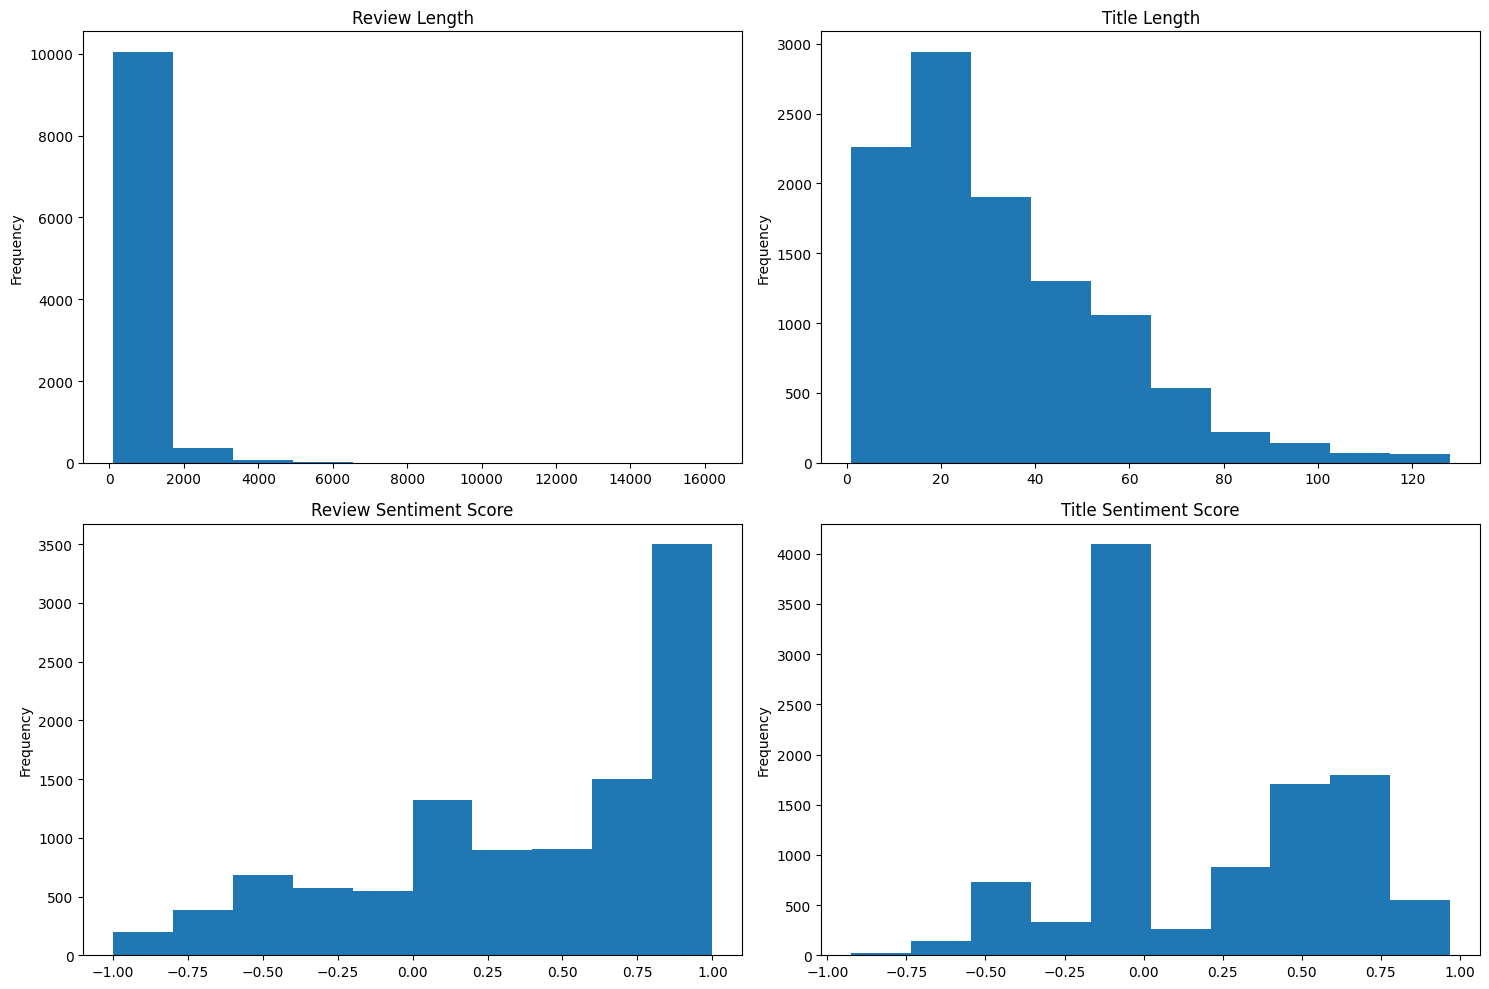

In [10]:
data_ad_y = data_ad[data_ad["anomaly"] == 1]

fig, axs = plt.subplots(2, 2,figsize=(15, 10))

# Plot data in each subplot
data_ad_y["REVIEW_LENGTH"].plot(kind="hist", ax=axs[0,0])
axs[0,0].set_title("Review Length")

data_ad_y["REV_TITLE_LENGTH"].plot(kind="hist", ax=axs[0,1])
axs[0,1].set_title("Title Length") 

data_ad_y["REVIEW_SCORE"].plot(kind="hist", ax=axs[1,0])
axs[1,0].set_title("Review Sentiment Score")

data_ad_y["TITLE_SCORE"].plot(kind="hist", ax=axs[1,1])
axs[1,1].set_title("Title Sentiment Score")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

C:\Users\user2\AppData\Local\Temp\ipykernel_10592\3897424008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ad_y["LABEL"] = data["LABEL"][:].loc[data_ad_y.index]
C:\Users\user2\AppData\Local\Temp\ipykernel_10592\3897424008.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ad_y["PRODUCT_CATEGORY"] = data["PRODUCT_CATEGORY"][:].loc[data_ad_y.index]


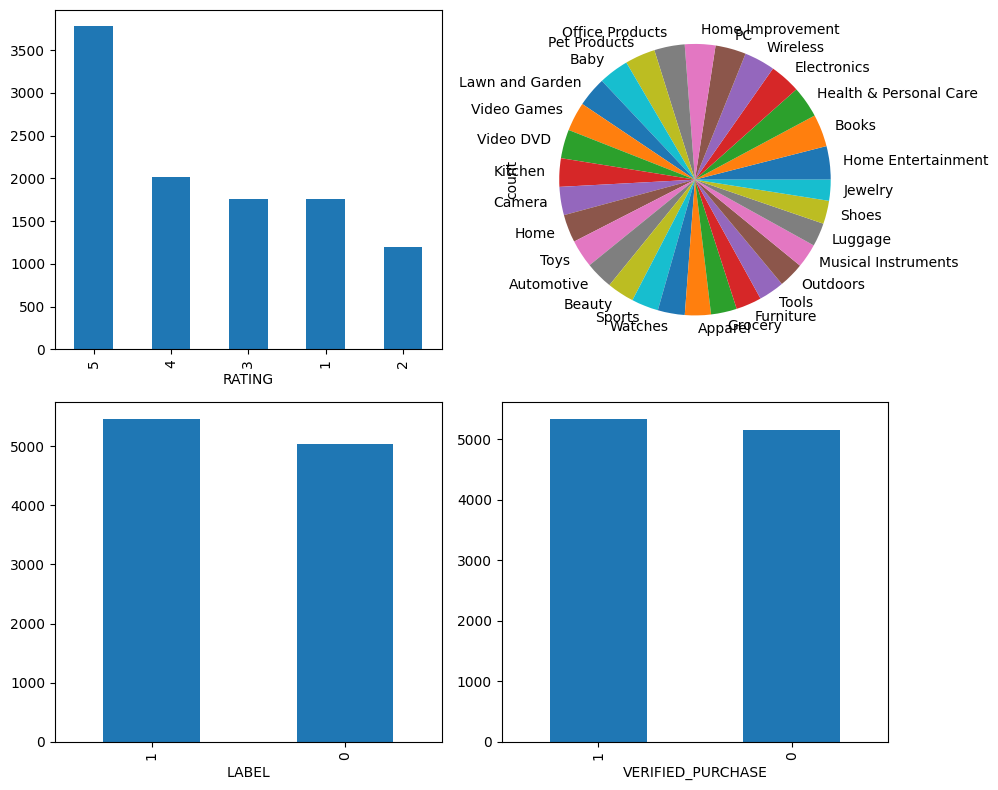

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
data_ad_y["LABEL"] = data["LABEL"][:].loc[data_ad_y.index]
data_ad_y["PRODUCT_CATEGORY"] = data["PRODUCT_CATEGORY"][:].loc[data_ad_y.index]

# Plot data in each subplot
data_ad_y["RATING"].value_counts().plot(kind="bar", ax=axs[0, 0])

data_ad_y["PRODUCT_CATEGORY"].value_counts().plot(kind="pie", ax=axs[0, 1])

data_ad_y["LABEL"].value_counts().plot(kind="bar", ax=axs[1, 0])

data_ad_y["VERIFIED_PURCHASE"].value_counts().plot(kind="bar", ax=axs[1, 1])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [14]:
data_ad_y["REVIEW_SCORE"].describe()

count    10500.000000
mean         0.384743
std          0.538139
min         -0.999700
25%          0.000000
50%          0.526700
75%          0.875450
max          0.998700
Name: REVIEW_SCORE, dtype: float64

In [9]:
data_ad[data_ad["anomaly"] == 1]["VERIFIED_PURCHASE"].value_counts()

VERIFIED_PURCHASE
1    5340
0    5160
Name: count, dtype: int64

In [15]:
data_ad_n = data_ad[data_ad["anomaly"] == 0]
data_ad_n["VERIFIED_PURCHASE"].value_counts()

VERIFIED_PURCHASE
1    6358
0    4142
Name: count, dtype: int64

In [16]:
data_ad_n["REVIEW_SCORE"].describe()

count    10500.000000
mean         0.732423
std          0.215520
min         -0.202300
25%          0.624900
50%          0.801550
75%          0.895700
max          0.991600
Name: REVIEW_SCORE, dtype: float64

Let's see some metrics

In [10]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
ad_accuracy = accuracy_score(data["LABEL"], data_ad["anomaly"])
ad_recall = recall_score(data["LABEL"], data_ad["anomaly"])
ad_precision = precision_score(data["LABEL"], data_ad["anomaly"])
print("Accuracy:", ad_accuracy)
print("Recall:", ad_recall)
print("Precision:", ad_precision)

Accuracy: 0.524
Recall: 0.524
Precision: 0.524


All metrics ended up equal, this is explained by the fact hat the model has equal number of false-positives and false-negatives, which could be possible when we set the 'contamination' parameter to 50% as we will find half the dataset to be anomalous. Isolation Forest correctly classified  around 52% of the dataset, that means that it had a pretty big error in distinguishing frauds from non-frauds.

### Principal Components Analysis + Anomaly Detection and Clustering

This wasn't very insightful, but a better way of understanding which values are anomalous is by plotting. We could reduce the dimensionality of the dataset through Principal Components Analysis, and visualize the observations in a 3D space to see what is happening. PCA reduces the dimensionality by finding the linear combinations of all fields retaining the most explained variance, for a preset number of components (in our case, 3)

In [20]:
#requires ipympl package installed, needed for interactive plots
#3d interactive plots are a bit resource consuming and not super fluid.
%matplotlib widget

Portion of variance retained after 3D PCA:  0.9999968277865575


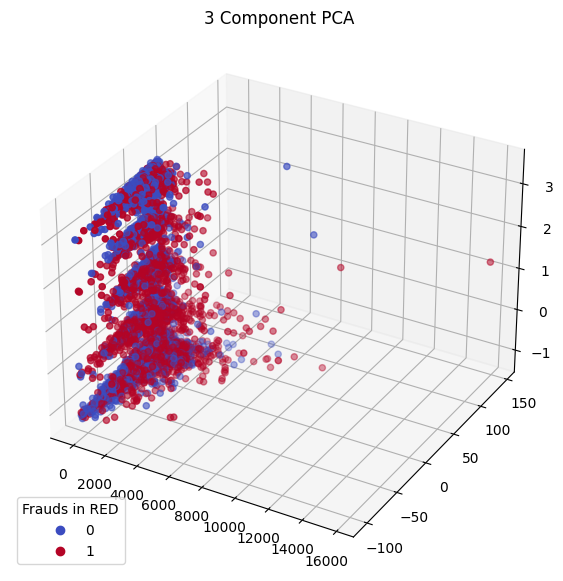

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
data_pca = data_ad.drop("anomaly", axis=1)
data_pca["LABEL"] = data["LABEL"][:]
pca = PCA(n_components=3)
data_pca = pca.fit_transform(data_pca)
#print portion of explained variance
print("Portion of variance retained after 3D PCA: ",sum(pca.explained_variance_ratio_))
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("3 Component PCA")
scatter = ax.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], c=data["LABEL"], cmap='coolwarm')
ax.legend(*scatter.legend_elements(),loc="lower left", title="Frauds in RED")

We can see here that although some blue (i.e. non-fraud) points start to deviate from the rest, the far away points tend to be red more frequently; even though many still lie close to all the other normal points.

What if we colored observations according to if they're anomalous or not?

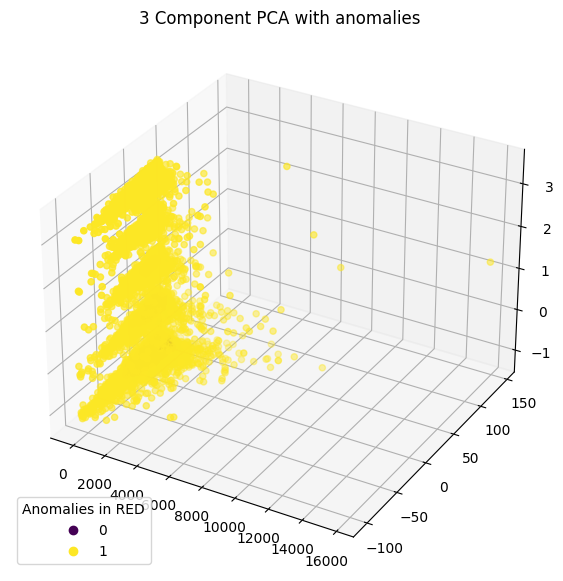

In [12]:
#create 3d plot and color anomalies different from other points
#for a better visualization, make sure to run the magic widget for interactive 3d plots
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("3 Component PCA with anomalies")
scatter = ax.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], c=data_ad["anomaly"])
ax.legend(*scatter.legend_elements(),loc="lower left", title="Anomalies in RED")

--[comment on above]

We could also cluster the observations into fraud/non-fraud clusters and visualize it in the plane.
We do so by using the K-Means algorithm and setting the K parameter as 2, which resembles the number of clusters(fraud/non-fraud). This algorithm's performance can depend on its random start, yet we will only fit it once.

C:\Users\user2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


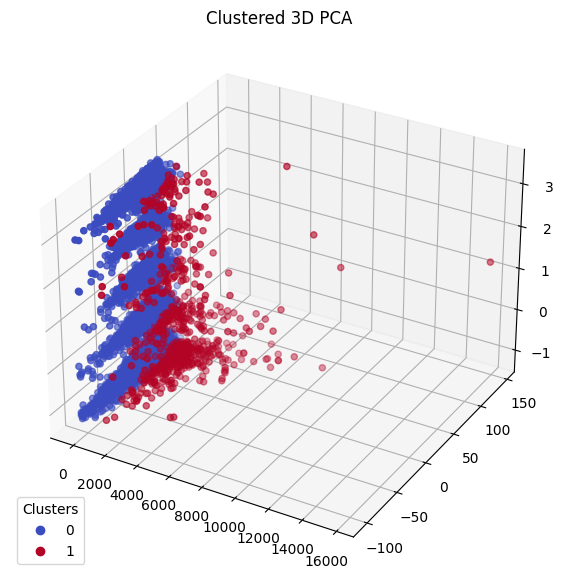

In [13]:
#2-cluster kmeans using the principal components
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(data_pca)
data_ad["cluster"] = kmeans.labels_
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Clustered 3D PCA")
scatter = ax.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], c=data_ad["cluster"], cmap='coolwarm')
ax.legend(*scatter.legend_elements(),loc="lower left", title="Clusters")

In [27]:
#check portion of frauds in each cluster
data_ad["LABEL"] = data["LABEL"][:]
frauds_in_cluster = data_ad.groupby("cluster")["LABEL"].sum()
total_in_cluster = data_ad["cluster"].value_counts()
fraud_portion = frauds_in_cluster / total_in_cluster
print("Fraud portion in each cluster: ",fraud_portion)

Fraud portion in each cluster:  cluster
0    0.488865
1    0.783375
dtype: float64


In [35]:
total_frauds = 10500
frauds_in_cluster/total_frauds

cluster
0    0.940762
1    0.059238
Name: LABEL, dtype: float64

In [30]:
total_in_cluster

cluster
0    20206
1      794
Name: count, dtype: int64

Here we can see that when grouping into clusters frauds and non-frauds can end up together, since the more outlying points are put in the red cluster regardless of being a fraud or not, and the points more on the left follow a similar dynamic.

We could still build some models which, at the expense of some insight can predict whether an observations is anomalous or not; we will do this through an XGBoost model for classification as it is known to be very powerful.

But first let's retry to have some explainability by fitting a shallow decision tree so that we can visualize its splits and get some insights.

In [54]:
data = backup[:]

In [14]:
data = data.drop(['REVIEW_TEXT','REVIEW_TITLE','PRODUCT_TITLE','PRODUCT_CATEGORY','PREPROCESSED_REVIEW','PREPROCESSED_TITLE'],axis=1)
display(data)

,LABEL,RATING,VERIFIED_PURCHASE,REVIEW_LENGTH,REV_TITLE_LENGTH,TITLE_SCORE,REVIEW_SCORE
0,0,4,0,116,6,0.0000,0.4939
1,0,4,1,404,21,0.0000,0.7517
2,0,3,0,248,24,-0.2057,0.4059
3,0,4,0,212,16,0.6249,0.0000
4,0,4,0,331,21,0.0000,0.6249
...,...,...,...,...,...,...,...
20995,1,4,1,100,20,0.6249,0.4019
20996,1,4,1,115,11,0.6369,0.6369
20997,1,5,1,297,57,0.8481,0.9182
20998,1,5,1,287,43,0.8834,0.6486


In [16]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score
clf = DecisionTreeClassifier(max_depth=3)
# We first drop duplicates, and we know we dont have nulls in our dataset
data = data.drop_duplicates()
data = data[data["REVIEW_LENGTH"] < 1.5*np.std(data["REVIEW_LENGTH"])] #remove outliers (IQR)
X =  data.drop('LABEL',axis=1)
y = data['LABEL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0,stratify=y)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
test_auc = roc_auc_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test AUC:", test_auc)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test Accuracy:", test_accuracy)

Test AUC: 0.8104881952459633
Test Precision: 0.7529015350056159
Test Recall: 0.8878587196467991
Test Accuracy: 0.8070915998311524


Now to visualize the tree splits:

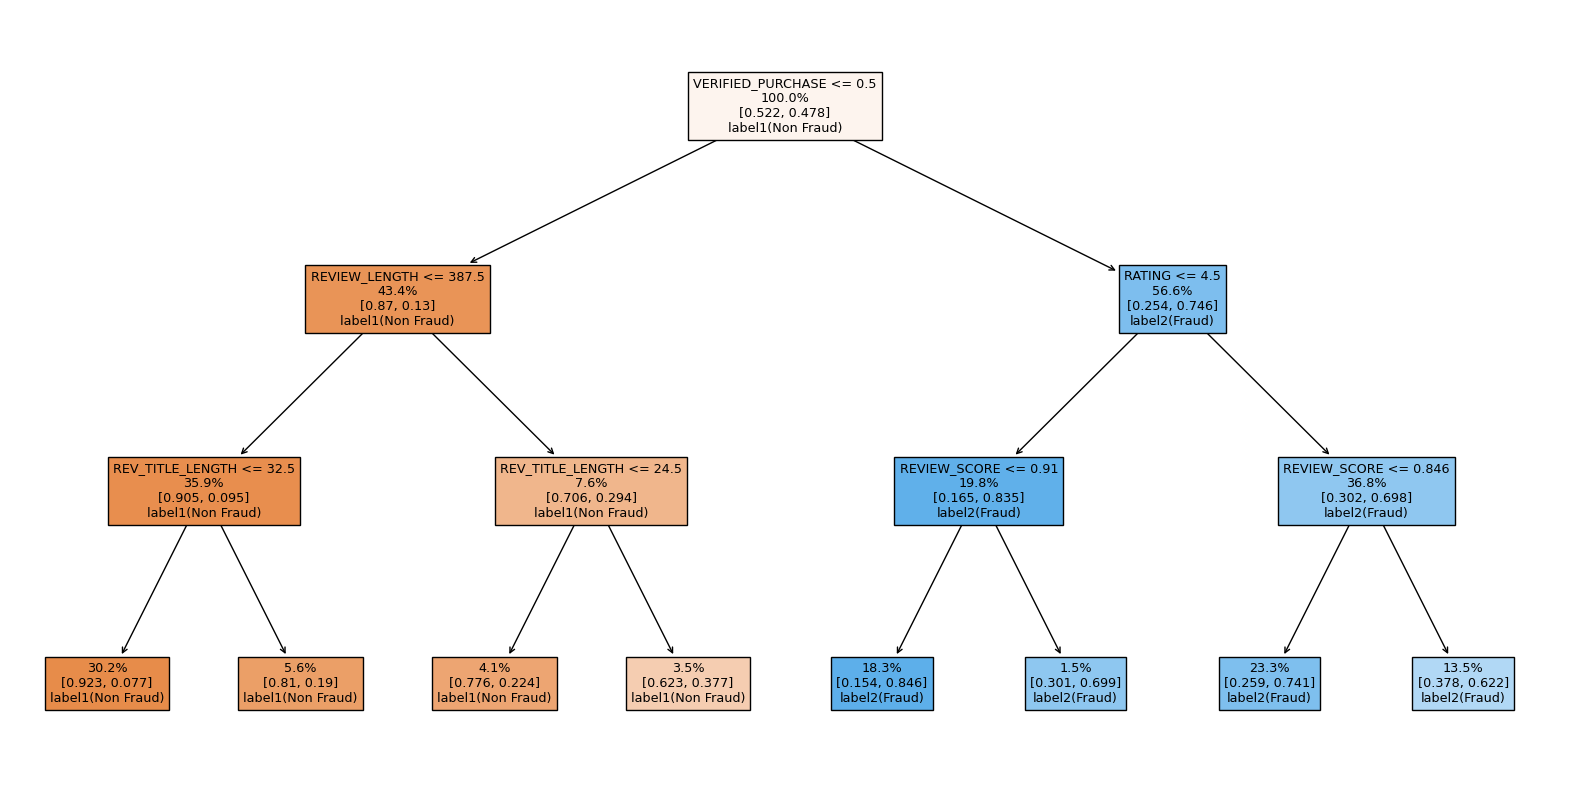

In [17]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=list(X.columns), class_names=["label1(Non Fraud)", "label2(Fraud)"], impurity=False, proportion=True,label='none')
plt.show()

From this tree we gain some good insights, mainly:
- a purchase being verified is a big indicator of possible fraud: first things first this model would check if the purchase is verified, and the end result would change drastically as a consequence, you can see that if a purchase was verified the model would classify the observation as a fraud(which is strange), even through this simple reasoning, it achieved a test AUC of around 0.8

With that said, let's delve into a more complex model and see with what performance we are able to detect/predict fraudulent reviews.

In [40]:
#Drop the text fields if you havent yet; save the current data in a backup
backup = data.copy()[:]
data = data.drop(['REVIEW_TEXT','REVIEW_TITLE','PRODUCT_TITLE','PRODUCT_CATEGORY','PREPROCESSED_REVIEW','PREPROCESSED_TITLE'],axis=1)
display(data)

,LABEL,RATING,VERIFIED_PURCHASE,REVIEW_LENGTH,REV_TITLE_LENGTH,TITLE_SCORE,REVIEW_SCORE
0,0,4,0,116,6,0.0000,0.4939
1,0,4,1,404,21,0.0000,0.7517
2,0,3,0,248,24,-0.2057,0.4059
3,0,4,0,212,16,0.6249,0.0000
4,0,4,0,331,21,0.0000,0.6249
...,...,...,...,...,...,...,...
20995,1,4,1,100,20,0.6249,0.4019
20996,1,4,1,115,11,0.6369,0.6369
20997,1,5,1,297,57,0.8481,0.9182
20998,1,5,1,287,43,0.8834,0.6486


In [61]:
#OPTIONAL: standardize the length fields (tends to decrease performance)
data["REVIEW_LENGTH"] = (data["REVIEW_LENGTH"] - data["REVIEW_LENGTH"].mean()) / data["REVIEW_LENGTH"].std()
data["REV_TITLE_LENGTH"] = (data["REV_TITLE_LENGTH"] - data["REV_TITLE_LENGTH"].mean()) / data["REV_TITLE_LENGTH"].std()
display(data)

,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,REVIEW_LENGTH,REV_TITLE_LENGTH,TITLE_SCORE,REVIEW_SCORE
0,1,4,0,PC,-0.533448,-1.049699,0.0000,0.4939
1,1,4,1,Wireless,0.065917,-0.261582,0.0000,0.7517
2,1,3,0,Baby,-0.258739,-0.103959,-0.2057,0.4059
3,1,4,0,Office Products,-0.333660,-0.524288,0.6249,0.0000
4,1,4,0,Beauty,-0.086006,-0.261582,0.0000,0.6249
...,...,...,...,...,...,...,...,...
20995,0,4,1,Shoes,-0.566746,-0.314123,0.6249,0.4019
20996,0,4,1,Shoes,-0.535529,-0.786993,0.6369,0.6369
20997,0,5,1,Shoes,-0.156764,1.629898,0.8481,0.9182
20998,0,5,1,Shoes,-0.177575,0.894322,0.8834,0.6486


It is time to implement and test our XGBoost model, here is the strategy:
- we split data into training and test set
-  we do cross validation through a parameter pool to find the best combination of hyperparameters achieving the highest AUC(by fitting on train data)
- we evaluate model performance on the test data

In [18]:
X = data.drop('LABEL',axis=1)
y = data['LABEL'][:]
display(data)

,LABEL,RATING,VERIFIED_PURCHASE,REVIEW_LENGTH,REV_TITLE_LENGTH,TITLE_SCORE,REVIEW_SCORE
0,0,4,0,116,6,0.0000,0.4939
1,0,4,1,404,21,0.0000,0.7517
2,0,3,0,248,24,-0.2057,0.4059
3,0,4,0,212,16,0.6249,0.0000
4,0,4,0,331,21,0.0000,0.6249
...,...,...,...,...,...,...,...
20994,1,5,1,101,48,0.2263,0.5267
20995,1,4,1,100,20,0.6249,0.4019
20996,1,4,1,115,11,0.6369,0.6369
20997,1,5,1,297,57,0.8481,0.9182


In [19]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier()
# define possible hyperparameters to find best combination
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}
#create GridSearch instane and start cross validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

#get the best model
best_model = grid_search.best_estimator_

Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}


In [20]:
#our best model obtains an Area Under the Curve of...
xgb_preds = best_model.predict(X_test)
xgb_auc = roc_auc_score(y_test, xgb_preds)
xgb_auc

0.8017662540752997

Thankfully, xgb offers a variable importance(F-score) plot, so we can visualize what were the fields which were affecting the model decision the most

<Figure size 1000x700 with 0 Axes>

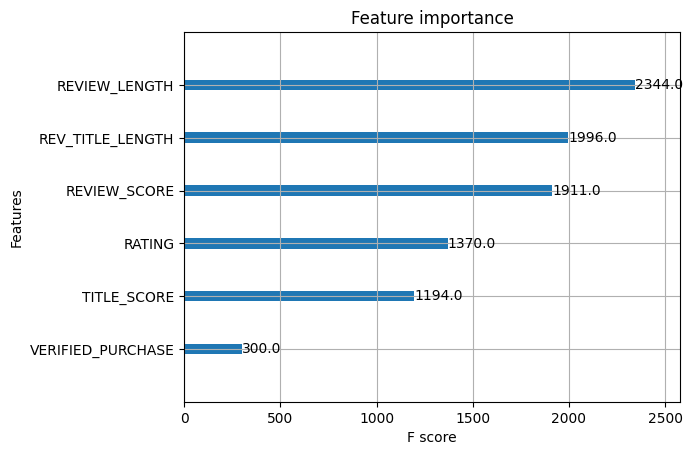

In [21]:
from xgboost import plot_importance
plt.figure(figsize=(10, 7))
plot_importance(best_model, importance_type='weight')
plt.show()

Some insights:
- Review length was the most impactful factor, 
- strangely verified purchase was the most useless this time, but since XGBoost is way more complex than the shallow Decision Tree it probably found some relationships which better explained the frauds' behavior.

In [22]:
xgb_precision = precision_score(y_test, xgb_preds)
xgb_recall = recall_score(y_test, xgb_preds)
xgb_accuracy = accuracy_score(y_test, xgb_preds)
print("We look at and explain the model metrics as:")
print("Precision (when our model flags a fraud, it is right ", round(xgb_precision,3)*100, "% of the time)")
print("Recall (our model is able to catch ", round(xgb_recall,3)*100, "% of the anomalies)")
print("Accuracy (our model can correctly identify ", round(xgb_accuracy,3)*100, "% of frauds and non-frauds overall)" )

We look at and explain the model metrics as:
Precision (when our model flags a fraud, it is right  73.9 % of the time)
Recall (our model is able to catch  88.5 % of the anomalies)
Accuracy (our model can correctly identify  79.7 % of frauds and non-frauds overall)


## Conclusions
In the given data:
- frauds and non-frauds are not so easy to distinguish
- simpler models favor purchase verification, while more complex ones care about length of review, sentiment and rating more
- frauds and non-frauds might show similar patterns and be grouped in the same clusters when measuring similarity
- frauds and non-frauds can show very similar sentiments